By default Scikit-Learn caches downloaded datasets in a directory called $HOME/scikit_learn_data.

In [32]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame= False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure includ
ing:
 • A DESCR key describing the dataset
 • A data key containing an array with one row per instance and one column per
 feature
 • A target key containing an array with the labels

Let’s look at these arrays:

In [33]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [34]:
y.shape

(70000,)

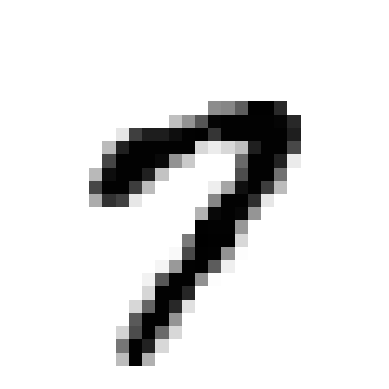

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[15]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [36]:
y[15]

'7'

The label is a string. We prefer numbers, so let’s cast y to integers

In [37]:
import numpy as np
y = y.astype(np.uint8)

Create a test set and set it aside before inspecting the data
closely. The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [38]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier

In [39]:
y_train_7 = (y_train == 7)  # True for all 7s, False for all other digits.
y_test_7 = (y_test == 7)  # True for all 7s, False for all other digits.

#Let’s create an SGDClassifier and train it on the whole training set:

In [40]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

SGDClassifier(random_state=42)

 Now you can use it to detect images of the number 7
 

In [41]:
sgd_clf.predict([some_digit])

array([ True])

Performance Measures
Let’s use the cross_val_score() function to evaluate your SGDClassifier model
using K-fold cross-validation, with three folds

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.98105, 0.9735 , 0.95335])

Confusion Matrix 
The better way to evaluate the performance of a classifier is to look at the confusion matrix.
To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets.

In [43]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)

 Just like the cross_val_score() function, cross_val_predict() performs K-fold
 cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

Now you are ready to get the confusion matrix using the confusion_matrix() func
tion. Just pass it the target classes (y_train_5) and the predicted classes
 (y_train_pred)

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_7, y_train_pred)

array([[52581,  1154],
       [  688,  5577]])

 Precision and Recall

In [45]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_7, y_train_pred)


0.8285544495617293

In [46]:
recall_score(y_train_7, y_train_pred)

0.8901835594573024

In [47]:
from sklearn.metrics import f1_score
f1_score(y_train_7, y_train_pred)

0.858264081255771

To compute the F1 score, simply call the f1_score() function:

In [48]:
from sklearn.metrics import f1_score
f1_score(y_train_7, y_train_pred)

0.858264081255771

 Precision/Recall Tradeof

In [49]:
# Need to get the scores of all instances in the training set using the cross_val_predict()
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3, method="decision_function")

In [50]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

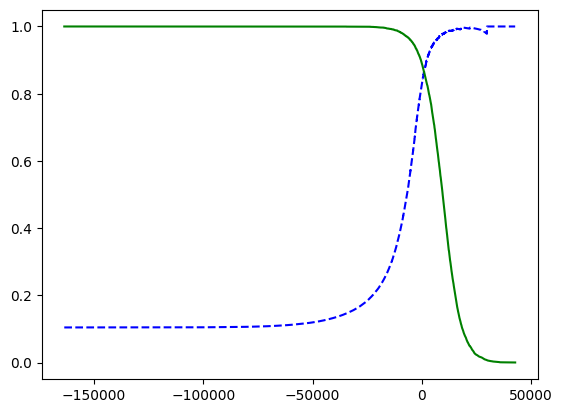

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold, add the legend, axis label and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The ROC curve plots the true positive rate (another name for recall) against the false positive rate.

In [52]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

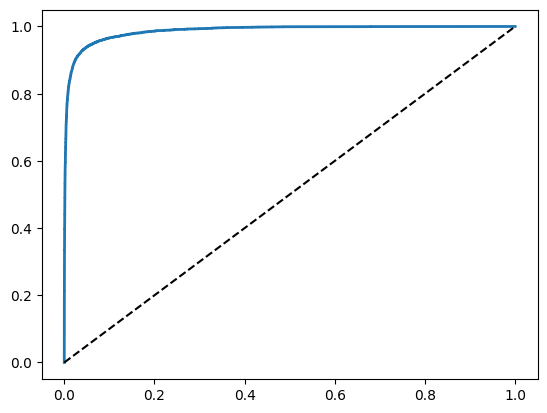

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

 Multiclass Classification

In [54]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([7], dtype=uint8)

In [55]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-21644.21154705, -30813.5490348 , -24237.31532374,
         -9608.2729414 , -12980.58270687,  -7511.22550981,
        -39999.81058079,   6397.47330052,  -2860.94256874,
          1049.86877291]])

In [56]:
np.argmax(some_digit_scores)
 

np.int64(7)

 The highest score is indeed the one corresponding to class 3:

In [57]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [58]:
sgd_clf.classes_[3]

np.uint8(3)

 If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
 the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance
 and pass a binary classifier to its constructor. For example, this code creates a multi
class classifier using the OvO strategy, based on a SGDClassifier:

In [59]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([7], dtype=uint8)

In [60]:
len(ovo_clf.estimators_)# number of classifiers were made

45

 Training a RandomForestClassifier is just as easy:

In [61]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([7], dtype=uint8)

To get the list of probabilities that the classifier assigned to each
instance for each class

In [62]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

to evaluate these classifiers

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Simply scaling the inputs (as discussed in Chapter 2) increases accuracy:

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Error Analysis
Look at the confusion matrix 

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

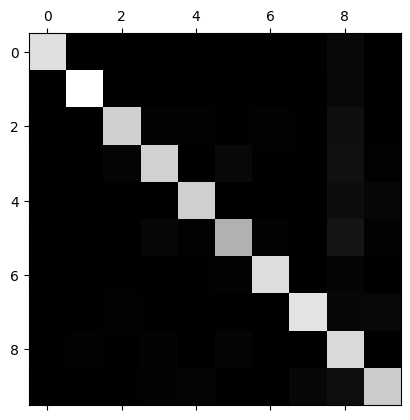

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()